### Sentiment analisys with LSTM

In [26]:
!pip install torchutils torchmetrics nltk -q

In [27]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
import string
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchutils as tu
from torchmetrics.classification import BinaryAccuracy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [29]:
df = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
def data_preprocessing(text: str) -> str:
    # удаляем html-теги, стоп-слова, пунктуацию, приводим к нижнему регистру

    text = text.lower()
    text = re.sub('<.*?>', '', text) # html tags
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [31]:
def get_words_by_freq(sorted_words: list, n: int = 10) -> list: # фильтруем часто встречающиеся слова
    return list(filter(lambda x: x[1] > n, sorted_words))

In [32]:
df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()
sorted_words = get_words_by_freq(sorted_words, 100)
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
reviews_int = []
for text in df['cleaned_reviews']:

    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [33]:
def padding(review_int: list, seq_len: int) -> np.array:
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [34]:
SEQ_LEN = 128
features = padding(reviews_int, SEQ_LEN)
print(features[3, :])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  572  124  136
   37  327 3493 1071  124  908 4207  630  883    1 1794 1248  958 3493
  933  302 5835  380   19  215   70   23    2  110  993  653  363  363
    1 1588  630 6564    4   54   42 3493 4207  329 3888    2  720   10
  607    1  197  174  363 3685  653  193   13  278  630 4471 3125  512
 3493 2584]


In [35]:
def preprocess_single_string(input_string: str, seq_len: int, vocab_to_int: dict = vocab_to_int) -> list:
    # предыдущие шаги предобработки в одной функции

    preprocessed_string = data_preprocessing(input_string)
    result_list = []
    for word in preprocessed_string.split():
        try:
            result_list.append(vocab_to_int[word])
        except KeyError as e:
            print(f'{e}: not in dictionary!')
    result_padded = padding([result_list], seq_len)[0]

    return torch.tensor(result_padded)

preprocess_single_string('Great movie whataword movie, cool funny', 50)

'whataword': not in dictionary!


tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  15,   1,   1, 476,  64])

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=42)

In [37]:
BATCH_SIZE = 64

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [38]:
VOCAB_SIZE = len(vocab_to_int)+1

In [39]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: BATCH_SIZE x SEQ_LEN', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 128])
Sample input: 
 tensor([[   0,    0,    0,  ...,    2,  165, 6521],
        [   0,    0,    0,  ...,  589,  253, 4911],
        [   0,    0,    0,  ..., 2943, 5835,   45],
        ...,
        [   0,    0,    0,  ...,  241, 1382,  219],
        [   0,    0,    0,  ...,  602,   34, 3785],
        [   0,    0,    0,  ...,  494, 5823,    2]])
Sample input: 
 tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1])


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
class sentimentLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """

    def __init__(self,
                # объем словаря, с которым мы работаем, размер входа для слоя Embedding
                vocab_size: int,
                # размер выходного эмбеддинга каждый элемент последовательности
                # будет описан вектором такой размерности
                embedding_dim: int,
                # размерность hidden state LSTM слоя
                hidden_dim: int,
                # число слоев в LSTM
                n_layers: int,
                drop_prob=0.5) -> None:

        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            n_layers,
                            dropout=drop_prob,
                            batch_first=True
                            )

        self.dropout = nn.Dropout()

        self.fc1 = nn.Linear(hidden_dim * SEQ_LEN, 512)
        self.do = nn.Dropout()
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # self.batch_size = x.size(0)
        # hidden = self.init_hidden()
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc2(torch.tanh(self.do(self.fc1(lstm_out.flatten(1)))))
        sig_out = self.sigmoid(out)

        return sig_out

In [32]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64
N_LAYERS = 3

model = sentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS
)
model = model.to(device)

if os.path.exists('aux/sentiment_lstm.pt'):
    try:
        model.load_state_dict(torch.load('aux/sentiment_lstm.pt'))
    except Exception as e:
        print(f'Model and weights does not match. ')


In [33]:
tu.get_model_summary(
    model, sample_x.to(device)
)

Layer           Kernel         Output        Params             FLOPs
0_embedding    [32, 6674]   [64, 128, 32]     213,568           8,192
1_lstm                  -   [64, 128, 64]      91,648   5,174,722,560
2_fc1         [8192, 512]       [64, 512]   4,194,816     536,838,144
3_do                    -       [64, 512]           0               0
4_fc2            [512, 1]         [64, 1]         513          65,472
5_sigmoid               -         [64, 1]           0             256
Total params: 4,500,545
Trainable params: 4,500,545
Non-trainable params: 0
Total FLOPs: 5,711,634,624 / 5.71 GFLOPs
---------------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 6.50
Params size (MB): 17.17
Estimated Total Size (MB): 23.73


In [36]:
LR=0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

accuracy = BinaryAccuracy().to(device)

clip = .9
EPOCHS = 10

epoch_train_loss = []
epoch_val_loss = []
epoch_train_acc = []
epoch_val_acc = []

In [37]:
for epoch in tqdm(range(EPOCHS)):
    train_losses = []
    train_acc = []

    model.train()
    model.to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), labels.float())

        train_losses.append(loss.item())
        train_acc.append(accuracy(output.squeeze(),labels).item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
        optimizer.step()
        tu.plot_gradients(
            model.cpu(),
            f'./grad_figures/grad_0{epoch}.png',
            plot_type='line')
        model.to(device)
    # epoch_train_loss.append(np.mean(train_losses))
    # epoch_train_acc.append(np.mean(train_acc))


    val_losses = []
    val_acc = []

    model.eval()
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)
        loss = criterion(output.squeeze(), labels.float())

        val_losses.append(loss.item())
        val_acc.append(accuracy(output.squeeze(),labels).item())


    epoch_train_loss.append(np.mean(train_losses))
    epoch_val_loss.append(np.mean(val_losses))
    epoch_train_acc.append(np.mean(train_acc))
    epoch_val_acc.append(np.mean(val_acc))


    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss[-1]:.4f} val_loss : {epoch_val_loss[-1]:.4f}')
    print(f'train_accuracy : {epoch_train_acc[-1]:.2f} val_accuracy : {epoch_val_acc[-1]:.2f}')

    if epoch > 3 and epoch_val_loss[-2] > epoch_val_loss[-1]:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/output/model_epoch_{epoch}.pt')
        print(f'Validation loss decreased ({epoch_val_loss[-2]:.3f} --> {epoch_val_loss[-1]:.3f}).  Saving model ...')

    print(25*'==')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6661 val_loss : 0.6110
train_accuracy : 0.58 val_accuracy : 0.66
Epoch 2
train_loss : 0.5925 val_loss : 0.5641
train_accuracy : 0.69 val_accuracy : 0.71
Epoch 3
train_loss : 0.5476 val_loss : 0.5276
train_accuracy : 0.72 val_accuracy : 0.74
Epoch 4
train_loss : 0.5015 val_loss : 0.4838
train_accuracy : 0.75 val_accuracy : 0.77
Epoch 5
train_loss : 0.4623 val_loss : 0.4617
train_accuracy : 0.78 val_accuracy : 0.79
Validation loss decreased (0.484 --> 0.462).  Saving model ...
Epoch 6
train_loss : 0.4362 val_loss : 0.4493
train_accuracy : 0.80 val_accuracy : 0.80
Validation loss decreased (0.462 --> 0.449).  Saving model ...


KeyboardInterrupt: 

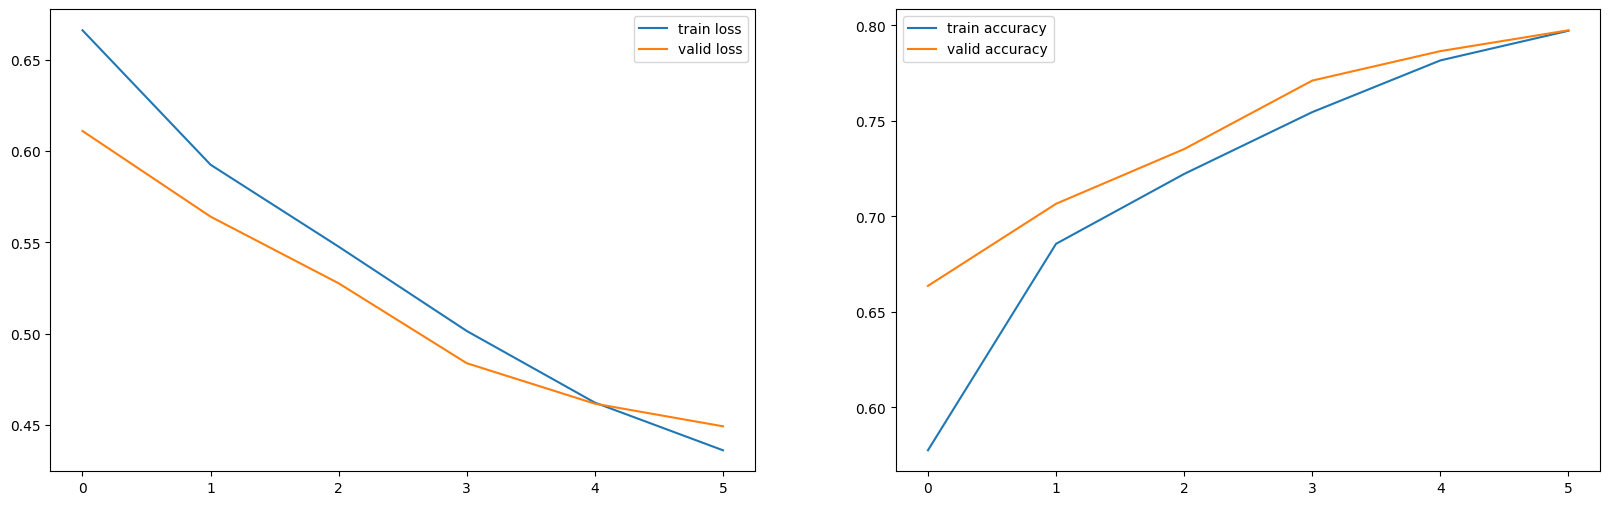

In [38]:
fig, ax  = plt.subplots(1, 2, figsize=(20, 6))
ax[0].set_xticks(range(EPOCHS))
ax[0].plot(epoch_train_loss, label='train loss')
ax[0].plot(epoch_val_loss, label='valid loss')
ax[0].legend()

ax[1].set_xticks(range(EPOCHS))
ax[1].plot(epoch_train_acc, label='train accuracy')
ax[1].plot(epoch_val_acc, label='valid accuracy')
ax[1].legend();

### Bidirectional LSTM

In [41]:
class sentimentLSTMBiDir(nn.Module):
    def __init__(self,
                # объем словаря, с которым мы работаем, размер входа для слоя Embedding
                vocab_size: int,
                # размер выходного эмбеддинга каждый элемент последовательности
                # будет описан вектором такой размерности
                embedding_dim: int,
                # размерность hidden state LSTM слоя
                hidden_dim: int,
                # число слоев в LSTM
                n_layers: int,
                drop_prob=0.5) -> None:

        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            n_layers,
                            dropout=drop_prob,
                            batch_first=True,
                            bidirectional=True
                            )

        self.dropout = nn.Dropout()

        self.fc1 = nn.Linear(hidden_dim * 2 * SEQ_LEN, 512)
        self.do = nn.Dropout()
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc2(torch.tanh(self.do(self.fc1(lstm_out.flatten(1)))))
        sig_out = self.sigmoid(out)

        return sig_out

In [42]:
EMBEDDING_DIM_BD = 32
HIDDEN_DIM_BD = 64
N_LAYERS_BD = 2

model_bd = sentimentLSTMBiDir(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM_BD,
    hidden_dim=HIDDEN_DIM_BD,
    n_layers=N_LAYERS_BD
)
model_bd = model_bd.to(device)

In [43]:
LR_BD=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_bd.parameters(), lr=LR_BD)

accuracy = BinaryAccuracy().to(device)

clip = .9
EPOCHS_BD = 10

epoch_train_loss_bd = []
epoch_val_loss_bd = []
epoch_train_acc_bd = []
epoch_val_acc_bd = []

In [44]:
for epoch in tqdm(range(EPOCHS_BD)):
    train_losses_bd = []
    train_acc_bd = []

    model_bd.train()
    model_bd.to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_bd(inputs)
        loss = criterion(output.squeeze(), labels.float())

        train_losses_bd.append(loss.item())
        train_acc_bd.append(accuracy(output.squeeze(),labels).item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bd.parameters(), 0.8)
        optimizer.step()
        tu.plot_gradients(
            model_bd.cpu(),
            f'./grad_figures/grad_0{epoch}.png',
            plot_type='line')
        model_bd.to(device)

    val_losses_bd = []
    val_acc_bd = []

    model_bd.eval()
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_bd(inputs)
        loss = criterion(output.squeeze(), labels.float())

        val_losses_bd.append(loss.item())
        val_acc_bd.append(accuracy(output.squeeze(),labels).item())


    epoch_train_loss_bd.append(np.mean(train_losses_bd))
    epoch_val_loss_bd.append(np.mean(val_losses_bd))
    epoch_train_acc_bd.append(np.mean(train_acc_bd))
    epoch_val_acc_bd.append(np.mean(val_acc_bd))


    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss_bd[-1]:.4f} val_loss : {epoch_val_loss_bd[-1]:.4f}')
    print(f'train_accuracy : {epoch_train_acc_bd[-1]:.2f} val_accuracy : {epoch_val_acc_bd[-1]:.2f}')

    if epoch > 3 and epoch_val_loss_bd[-2] > epoch_val_loss_bd[-1]:
        torch.save(model_bd.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/output/LSTMBD_model_epoch_{epoch + 1}.pt')
        print(f'Validation loss decreased ({epoch_val_loss_bd[-2]:.3f} --> {epoch_val_loss_bd[-1]:.3f}).  Saving model ...')

    print(25*'==')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6089 val_loss : 0.5286
train_accuracy : 0.63 val_accuracy : 0.80
Epoch 2
train_loss : 0.3771 val_loss : 0.5189
train_accuracy : 0.84 val_accuracy : 0.81
Epoch 3
train_loss : 0.3105 val_loss : 0.4057
train_accuracy : 0.87 val_accuracy : 0.87
Epoch 4
train_loss : 0.2711 val_loss : 0.4361
train_accuracy : 0.89 val_accuracy : 0.87
Epoch 5
train_loss : 0.2383 val_loss : 0.4764
train_accuracy : 0.91 val_accuracy : 0.87
Epoch 6
train_loss : 0.2110 val_loss : 0.4621
train_accuracy : 0.92 val_accuracy : 0.87
Validation loss decreased (0.476 --> 0.462).  Saving model ...


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

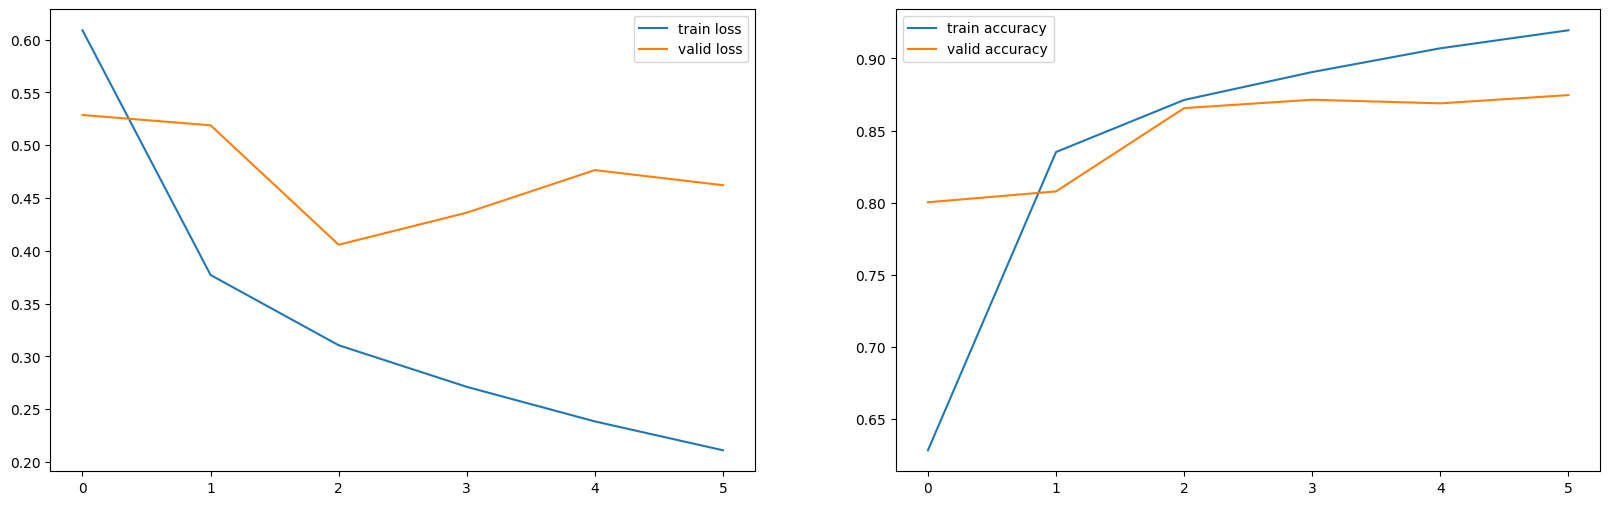

In [45]:
fig, ax  = plt.subplots(1, 2, figsize=(20, 6))
ax[0].set_xticks(range(EPOCHS_BD))
ax[0].plot(epoch_train_loss_bd, label='train loss')
ax[0].plot(epoch_val_loss_bd, label='valid loss')
ax[0].legend()

ax[1].set_xticks(range(EPOCHS_BD))
ax[1].plot(epoch_train_acc_bd, label='train accuracy')
ax[1].plot(epoch_val_acc_bd, label='valid accuracy')
ax[1].legend();